## Vehicle detection

The goal of this project is to detect vehicle within an image.
1. Extract HOG and color features. Use SVM as the training model
2. Use convolutional neural network

### 1. Feature extraction

Extract features from an image. We mainly focused on the HOG (Histogram of Oriented Gradient) and the color feature.

#### 1.1 HOG feature

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog

In [7]:
"""
This method returns HOG feature for a binary image.
If vis is True, it also return a HOG feature image.
If vec is True, the HOG feature is unroll.

[Attention] the input image must be a binary image.
"""
def get_hog(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, vec=True):
    
    if vis:
        features, hog_img = hog(img, orientations=orient, 
                            pixels_per_cell = (pix_per_cell, pix_per_cell),
                            cells_per_block = (cell_per_block, cell_per_block),
                            block_norm = 'L2-Hys',
                            visualise = True,
                            transform_sqrt = False,
                            feature_vector = vec)
        return features, hog_img
    else:
        features = hog(img, orientations=orient, 
                    pixels_per_cell = (pix_per_cell, pix_per_cell),
                    cells_per_block = (cell_per_block, cell_per_block),
                    block_norm = 'L2-Hys',
                    visualise = False,
                    transform_sqrt = False,
                    feature_vector = vec)
        return features

"""
This method returns a vector that consists of HOG vectors for every image channel.
It doesn't return HOG feature image and the feature vector is unrolled.
"""
def get_hog_all(image, orient=9, pix_per_cell=8, cell_per_block=2):
    feature_vec = []
    for channel in range(image.shape[2]):
        img = image[:, :, channel]
        feature = get_hog(img, orient, pix_per_cell, cell_per_block)
        feature_vec.append(feature)
    return np.hstack(feature_vec)

Visualize HOG feature for vehicle and non-vehicle image

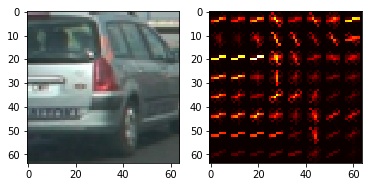

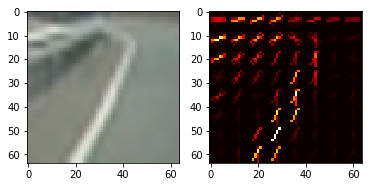

In [8]:
vehicle_img = mpimg.imread('vehicles/GTI_Left/image0168.png')
non_vehicle_img = mpimg.imread('non-vehicles/GTI/image168.png')

features, hog_img = get_hog(vehicle_img[:, :, 0], vis=True)
fig = plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(vehicle_img)
plt.subplot(122)
plt.imshow(hog_img, cmap='hot')
plt.show()

features, hog_img = get_hog(non_vehicle_img[:, :, 0], vis=True)
fig = plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(non_vehicle_img)
plt.subplot(122)
plt.imshow(hog_img, cmap='hot')
plt.show()

#### 1.2 color feature

In [9]:
"""
Convert color space for an image.
"""
def cvt_cspace(image, cspace='RGB'):
    if cspace == 'YCrCb':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    elif cspace == 'HLS':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif cspace == 'HSV':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif cspace == 'LAB':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    else:
        img = image
    return img

"""
This method returns a spatial bin feature for an image.
If vis is True, return the resize image.
"""
def get_bin_spatial(img, size=(32, 32), vis=False):
    ch_1 = cv2.resize(img[:, :, 0], size)
    ch_2 = cv2.resize(img[:, :, 1], size)
    ch_3 = cv2.resize(img[:, :, 2], size)
    feature_vec = np.hstack((ch_1.ravel(), ch_2.ravel(), ch_3.ravel()))
    imgs = []
    imgs.append(ch_1)
    imgs.append(ch_2)
    imgs.append(ch_3)
    if vis:
        return feature_vec, imgs
    else:
        return feature_vec
    
"""
This method returns a histogram of color space.
If vis is True, return the position and value for bars of a histogram.
"""
def get_color_hist(img, nbins=32, vis=False):
    hist_1 = np.histogram(img[:, :, 0], nbins)
    hist_2 = np.histogram(img[:, :, 1], nbins)
    hist_3 = np.histogram(img[:, :, 2], nbins)
    feature_vec = np.hstack((hist_1[0], hist_2[0], hist_3[0]))
    
    if vis:
        bin_edges = hist_1[1]
        bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
        return feature_vec, bin_centers, hist_1[0], hist_2[0], hist_3[0]
    else:
        return feature_vec

Let's take a look at bin spatial feature for YCrCb color space.

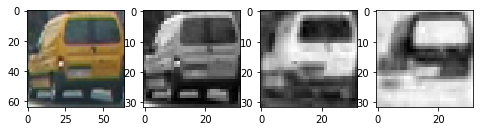

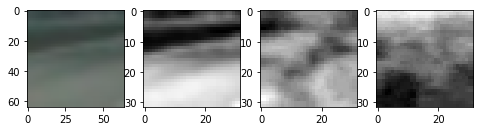

In [10]:
vehicle_img = mpimg.imread('vehicles/GTI_Right/image0862.png')
non_vehicle_img = mpimg.imread('non-vehicles/GTI/image200.png')

vehicle_YCrCb = cvt_cspace(vehicle_img, cspace='YCrCb')
features, small_imgs = get_bin_spatial(vehicle_YCrCb, vis=True)
fig = plt.figure(figsize=(8,6))
plt.subplot(141)
plt.imshow(vehicle_img)
plt.subplot(142)
plt.imshow(small_imgs[0], cmap='gray')
plt.subplot(143)
plt.imshow(small_imgs[1], cmap='gray')
plt.subplot(144)
plt.imshow(small_imgs[2], cmap='gray')
plt.show()

non_vehicle_YCrCb = cvt_cspace(non_vehicle_img, cspace='YCrCb')
features, small_imgs = get_bin_spatial(non_vehicle_YCrCb, vis=True)
fig = plt.figure(figsize=(8,6))
plt.subplot(141)
plt.imshow(non_vehicle_img)
plt.subplot(142)
plt.imshow(small_imgs[0], cmap='gray')
plt.subplot(143)
plt.imshow(small_imgs[1], cmap='gray')
plt.subplot(144)
plt.imshow(small_imgs[2], cmap='gray')
plt.show()

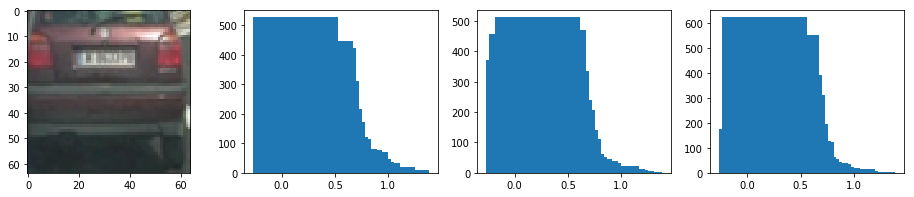

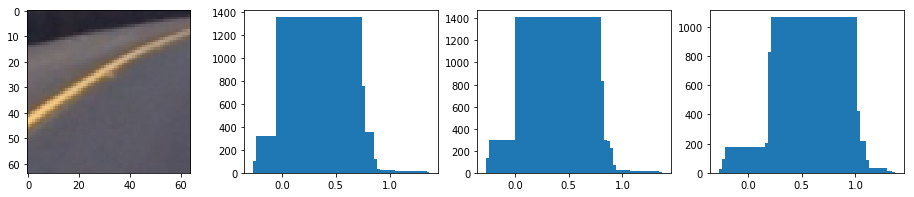

In [11]:
vehicle_img = mpimg.imread('vehicles/GTI_MiddleClose/image0092.png')
non_vehicle_img = mpimg.imread('non-vehicles/Extras/extra1006.png')

imgs = []
imgs.append(vehicle_img)
imgs.append(non_vehicle_img)

for img in imgs:
    features, bin_centers, hist1, hist2, hist3 = get_color_hist(img, vis=True)
    fig = plt.figure(figsize=(16,3))
    plt.subplot(141)
    plt.imshow(img)
    plt.subplot(142)
    plt.bar(bin_centers, hist1)
    plt.subplot(143)
    plt.bar(bin_centers, hist2)
    plt.subplot(144)
    plt.bar(bin_centers, hist3)
    plt.show()

#### 1.3 Combine HOG and color feature

In [21]:
"""
Extract feature from an image.
"""
def extract_feature_from_image(image, cspace='YCrCb', 
                               size=(32, 32), nbins=32, 
                               orient=9, pix_per_cell=8, cell_per_block=2):
    img = cvt_cspace(image, cspace)
    color_hist = get_color_hist(img, nbins)
    sp_bin = get_bin_spatial(img, size)
    hog = get_hog_all(img, orient, pix_per_cell, cell_per_block)
    vec = np.hstack((color_hist, sp_bin, hog))
    return vec

"""
Extract feature from a list of images and return a concatenated feature.
"""
def extract_features_from_imgs(imgs, cspace='YCrCb', 
                               size=(32, 32), nbins=32, 
                               orient=6, pix_per_cell=8, cell_per_block=2):
    features = []
    for img in imgs:
        feature = extract_feature_from_image(img, cspace, size, nbins, orient, pix_per_cell, cell_per_block)
        features.append(feature)
    return features

### 2. Train the model

#### 2.1 Read in car / not car images

In [14]:
import glob

car_files = glob.glob('./vehicles/*/*')
not_car_files = glob.glob('./non-vehicles/*/*')

car_imgs = []
not_car_imgs = []
for car_file in car_files:
    car_img = mpimg.imread(car_file)
    car_imgs.append(car_img)
    
for not_car_file in not_car_files:
    not_car_img = mpimg.imread(not_car_file)
    not_car_imgs.append(not_car_img)
    
print('Number of vehicle images:', len(car_imgs))
print('Number of non-vehicle images:', len(not_car_imgs))
print('Shape of the image:', car_imgs[0].shape)

Number of vehicle images: 8792
Number of non-vehicle images: 8968
Shape of the image: (64, 64, 3)


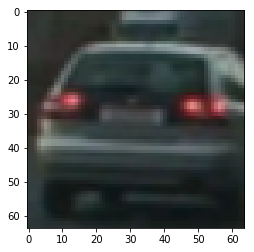

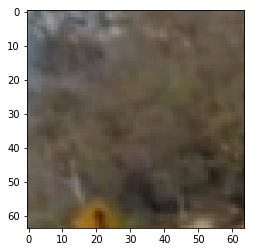

In [15]:
plt.imshow(car_imgs[666])
plt.show()
plt.imshow(not_car_imgs[777])
plt.show()

#### 2.2 Extract and normalize features.

1. Extract features
2. Normalize features
3. Split train/test data

In [22]:
orientation = 9
pix = 8
cell = 2
bins =32
sz = (32, 32)

In [23]:
car_features = extract_features_from_imgs(car_imgs, size=sz, nbins=bins, 
                               orient=orientation, pix_per_cell=pix, cell_per_block=cell)
not_car_features = extract_features_from_imgs(not_car_imgs, size=sz, nbins=bins, 
                               orient=orientation, pix_per_cell=pix, cell_per_block=cell)
print(len(car_features))
print(len(not_car_features))
print(car_features[0].shape)

8792
8968
(8460,)


In [24]:
X = np.vstack((car_features, not_car_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
print(X.shape)
print(y.shape)

(17760, 8460)
(17760,)


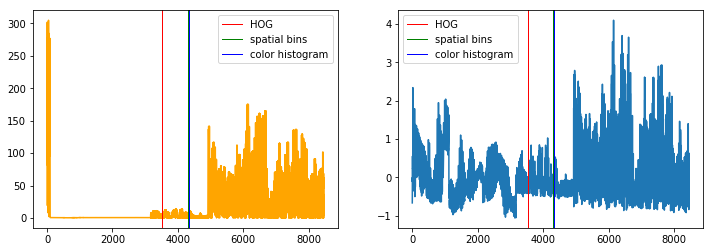

In [25]:
# Normalize
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(X[0], color='orange')
plt.axvline(x=3528, linewidth=1, color='r', label='HOG')
plt.axvline(x=4296, linewidth=1, color='g', label='spatial bins')
plt.axvline(x=4344, linewidth=1, color='b', label='color histogram')
plt.legend()

plt.subplot(122)
plt.plot(scaled_X[0])
plt.axvline(x=3528, linewidth=1, color='r', label='HOG')
plt.axvline(x=4296, linewidth=1, color='g', label='spatial bins')
plt.axvline(x=4344, linewidth=1, color='b', label='color histogram')
plt.legend()
plt.show()

In [26]:
# Split data
from sklearn.model_selection import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14208, 8460)
(14208,)
(3552, 8460)
(3552,)


#### 2.3 Train the model

In [27]:
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import time

In [28]:
t1 = time.time()
linear_clf = LinearSVC()
linear_clf.fit(X_train, y_train)
t2 = time.time()
acc = linear_clf.score(X_test, y_test)
print("Time: ", round(t2-t1, 5), ' Accuracy: ', acc)

Time:  29.69154  Accuracy:  0.985641891892


In [29]:
t1 = time.time()
rbf_clf = svm.SVC(kernel='rbf', C=10)
rbf_clf.fit(X_train, y_train)
t2 = time.time()
acc = rbf_clf.score(X_test, y_test)
print('Time: ', round(t2-t1, 5), ' Accuracy: ' ,acc)

Time:  270.47164  Accuracy:  0.993524774775


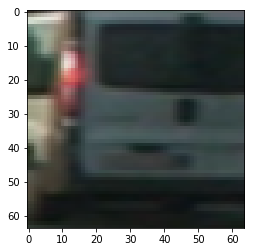

[ 1.]


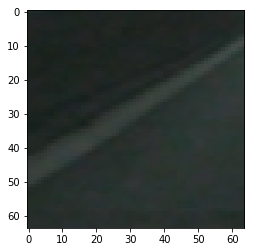

[ 0.]


In [30]:
rand_car_id = np.random.randint(len(car_imgs))
rand_not_car_id = np.random.randint(len(not_car_imgs))

car_img = car_imgs[rand_car_id]
not_car_img = not_car_imgs[rand_not_car_id]

feature1 = extract_feature_from_image(car_img, size=sz, nbins=bins, 
                               orient=orientation, pix_per_cell=pix, cell_per_block=cell)
X = X_scaler.transform(np.array(feature1).reshape(1, -1))
y = linear_clf.predict(X)
plt.imshow(car_img)
plt.show()
print(y)

feature2 = extract_feature_from_image(not_car_img, size=sz, nbins=bins, 
                               orient=orientation, pix_per_cell=pix, cell_per_block=cell)
X = X_scaler.transform(np.array(feature2).reshape(1, -1))
y = linear_clf.predict(X)
plt.imshow(not_car_img)
plt.show()
print(y)

### 3. Sliding Window Search

In [45]:
"""
Given a list of bounding boxes, draw them on the image.
"""
def draw_boxes(image, bboxes, color=(0, 0, 255), thickness=6):
    img = np.copy(image)
    for bbox in bboxes:
        cv2.rectangle(img, bbox[0], bbox[1], color, thickness)
    return img

#### 3.1 Same window size

Let's implement the very basic version of searching algorithm. It creates sliding windows with the same size.

In [32]:
def slid_win(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Range in x,y direction
    range_x = x_start_stop[1] - x_start_stop[0]
    range_y = y_start_stop[1] - y_start_stop[0]
    # Pixels per step in x,y direction
    x_step_pix = np.int(xy_window[0] * (1-xy_overlap[0]))
    y_step_pix = np.int(xy_window[1] * (1-xy_overlap[1]))
    # Buffer in x,y direction
    x_buffer = np.int(xy_window[0] * xy_overlap[0])
    y_buffer = np.int(xy_window[1] * xy_overlap[1])
    # Number of windows
    n_win_x = np.int((range_x - x_buffer)/x_step_pix)
    n_win_y = np.int((range_y - y_buffer)/y_step_pix)
    
    bboxes = []
    for i in range(n_win_x):
        for j in range(n_win_y):
            top_left_x = x_step_pix * i + x_start_stop[0]
            top_left_y = y_step_pix * j + y_start_stop[0]
            bottom_right_x = top_left_x + xy_window[0]
            bottom_right_y = top_left_y + xy_window[1]
            bboxes.append(((top_left_x, top_left_y), (bottom_right_x, bottom_right_y)))
    return bboxes

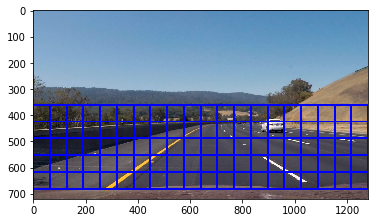

In [33]:
img = mpimg.imread('./test_images/test3.jpg')

bboxes = slid_win(img, y_start_stop=[np.int(img.shape[0]/2), img.shape[0]], 
                    xy_window=(128, 128))
out = draw_boxes(img, bboxes)
plt.imshow(out)
plt.show()

#### 3.2 Perspective sliding windows

Perspective sliding windows take into the account of perspective transformation. The farther the window it is, the smaller it appears; The closer the window it is, the larger it appears.

In [34]:
"""
Perspective sliding window. 

Inputs:
x_start_stop, y_start_stop: defines the region of interest
xy_window: defines the TOP-MOST window size
xy_overlap: defines the ratio of overlaping area between two windows
ratio: (1 + y_distance * ratio) would be the size of a new window

Outputs:
A list of bounding boxes.
"""
def perspective_slid_win(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5), ratio=1/300.):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
     
    bboxes = []
    win = xy_window # current window size
    top = y_start_stop[0] # upper bound of bbox
    bottom = top + win[1] # lower bound of bbox
    
    while bottom <= y_start_stop[1]:
        left = x_start_stop[0]
        right = left + win[0]
        pix_x = np.int(win[0]*(1-xy_overlap[0])) # pixel per step in x direction
        while right <= x_start_stop[1]:
            bboxes.append(((left, top), (right, bottom)))
            left += pix_x
            right = left + win[0]
        # update window size
        pix_y = np.int(win[1]*(1-xy_overlap[1])) # pixel per step in y direction
        scale = 1 + pix_y * ratio
        win_x = np.int(win[0]*scale)
        win_y = np.int(win[1]*scale)
        win = (win_x, win_y)
        top += pix_y
        bottom = top + win[1]
    return bboxes

In [35]:
"""
Search from right
"""
"""
Perspective sliding window. 

Inputs:
x_start_stop, y_start_stop: defines the region of interest
xy_window: defines the TOP-MOST window size
xy_overlap: defines the ratio of overlaping area between two windows
ratio: (1 + y_distance * ratio) would be the size of a new window

Outputs:
A list of bounding boxes.
"""
def perspective_slid_win_right(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5), ratio=1/300.):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
     
    bboxes = []
    win = xy_window # current window size
    top = y_start_stop[0] # upper bound of bbox
    bottom = top + win[1] # lower bound of bbox
    
    while bottom <= y_start_stop[1]:
        right = x_start_stop[1]
        left = right - win[0]
        pix_x = np.int(win[0]*(1-xy_overlap[0])) # pixel per step in x direction
        while left >= x_start_stop[0]:
            bboxes.append(((left, top), (right, bottom)))
            right -= pix_x
            left = right - win[0]
        # update window size
        pix_y = np.int(win[1]*(1-xy_overlap[1])) # pixel per step in y direction
        scale = 1 + pix_y * ratio
        win_x = np.int(win[0]*scale)
        win_y = np.int(win[1]*scale)
        win = (win_x, win_y)
        top += pix_y
        bottom = top + win[1]
    return bboxes

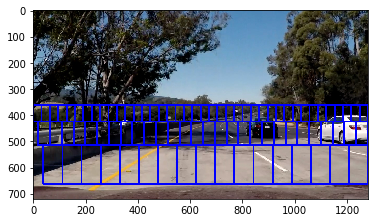

In [36]:
img = mpimg.imread('./test_images/test5.jpg')

bboxes = perspective_slid_win_right(img, y_start_stop=[np.int(img.shape[0]/2), img.shape[0]], xy_window=(64, 64), xy_overlap=(0.5, 0), ratio=1/150.)
out = draw_boxes(img, bboxes)
plt.imshow(out)
plt.show()

#### 3.3 Multi-scale sliding window

Now that we've implemented a perspective sliding window algorithm, we can feed it with various window sizes for the top-most windows

In [37]:
"""
Generate sliding windows with multi scales.
win_small: small window size
win_big: big window size
inc: increment from small to big window size
"""
def multi_slid_win(img, x_start_stop=[None, None], y_start_stop=[None, None],
                  win_small=32, win_big=64, inc=8,
                  overlap=(0.5, 0.5), r=1/300.):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    bboxes = []
    win = win_small
    while win <= win_big:
        win_x = win
        win_y = np.int(win*0.5)
        out = perspective_slid_win(img, x_start_stop, y_start_stop, xy_window=(win_x, win_y), xy_overlap=overlap, ratio=r)
        bboxes.extend(out)
        win += inc
    return bboxes

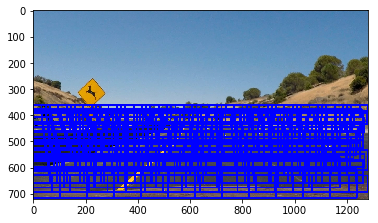

In [38]:
img = mpimg.imread('./test_images/test2.jpg')

bboxes = multi_slid_win(img, y_start_stop=[np.int(img.shape[0]/2), img.shape[0]], win_small=64, win_big=128, inc=32)
out = draw_boxes(img, bboxes)
plt.imshow(out)
plt.show()

### 4. Search vehicle and apply heatmap

In [39]:
orientation = 9
pix = 8
cell = 2
bins =32
sz = (32, 32)

In [59]:
def search_windows(image, windows, clf, scaler):
    pos_wins = [] # windows contains positive result
    for win in windows:
        img = image[win[0][1]:win[1][1], win[0][0]:win[1][0], :]
        
        img = cv2.resize(img, (64, 64))
        feature = extract_feature_from_image(img, size=sz, nbins=bins, orient=orientation, pix_per_cell=pix, cell_per_block=cell)
        X = scaler.transform(np.array(feature).reshape(1, -1))
        y = clf.predict(X)
        if y == 1:
            #plt.imshow(img)
            #plt.show()
            pos_wins.append(win)
    return pos_wins

In [60]:
"""
Get a heatmap given positive windows and a threshold.
"""
def get_heatmap(img, pos_wins, threshold):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for win in pos_wins:
        # Add 1 for each pixel within the box
        heatmap[win[0][1]:win[1][1], win[0][0]:win[1][0]] += 1
    heatmap[heatmap <= threshold] = 0
    return heatmap

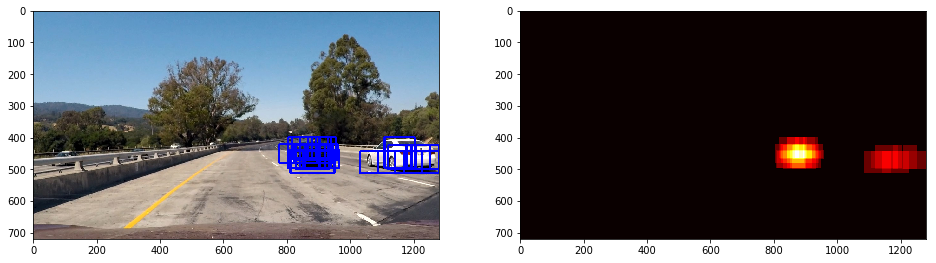

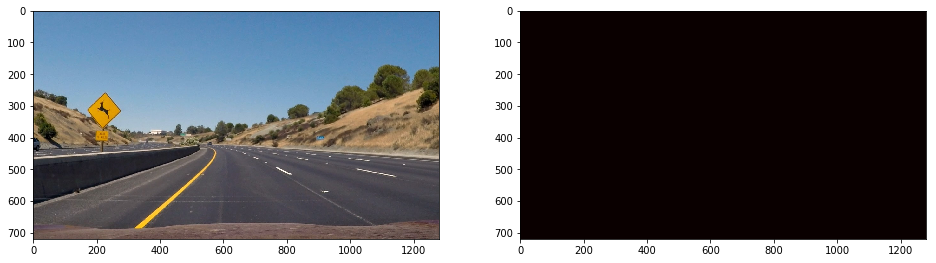

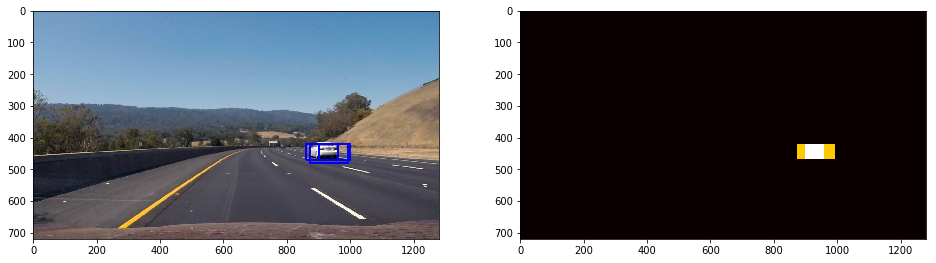

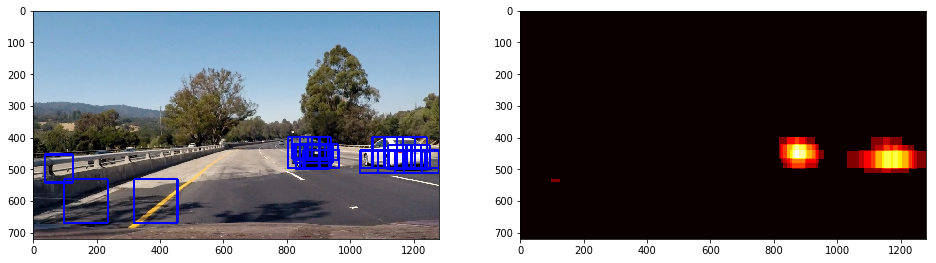

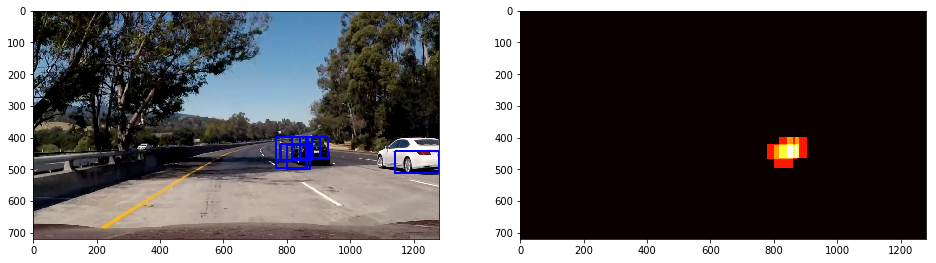

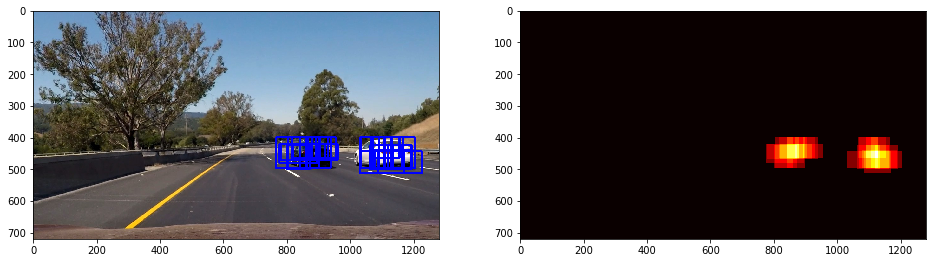

In [68]:
files = glob.glob('./test_images/test*.jpg')
for file in files:
    image = mpimg.imread(file)
    # This is very important
    
    
    img = image.astype(np.float32)/255
    
    
    
    
    #bboxes = multi_slid_win(img, y_start_stop=[420, img.shape[0]], win_small=64, win_big=256, inc=32)
    #bboxes = perspective_slid_win(img, y_start_stop=[420, img.shape[0]], xy_window=(128, 64), xy_overlap=(0.5, 0.5), ratio=1/150.)
    
    bounds = []
    #bboxes1 = slid_win(img, y_start_stop=[400, img.shape[0]], xy_window=(64, 64), xy_overlap=(0.6, 0.6))
    #bboxes2 = slid_win(img, y_start_stop=[400, img.shape[0]], xy_window=(96, 96), xy_overlap=(0.6, 0.6))
    #bboxes3 = slid_win(img, y_start_stop=[400, img.shape[0]], xy_window=(100, 50), xy_overlap=(0.8, 0.8))

    bboxes1 = perspective_slid_win_right(img, y_start_stop=[400, img.shape[0]], xy_window=(64, 64), xy_overlap=(0.6, 0.6), ratio=1/150.)
    bboxes2 = perspective_slid_win_right(img, y_start_stop=[400, img.shape[0]], xy_window=(96, 96), xy_overlap=(0.6, 0.6), ratio=1/150.)
    bboxes3 = perspective_slid_win_right(img, y_start_stop=[420, img.shape[0]], xy_window=(100, 50), xy_overlap=(0.6, 0.6), ratio=1/150.)
    bboxes4 = perspective_slid_win_right(img, y_start_stop=[420, img.shape[0]], xy_window=(120, 60), xy_overlap=(0.6, 0.6), ratio=1/150.)
    
    bounds.extend(bboxes1)
    bounds.extend(bboxes2)
    bounds.extend(bboxes3)
    bounds.extend(bboxes4)
    
    
    fig = plt.figure(figsize=(16,12))
    #pos_wins = search_windows(img, bounds, linear_clf, X_scaler)
    plt.subplot(121)
    pos_wins = search_windows(img, bounds, rbf_clf, X_scaler)
    out = draw_boxes(image, pos_wins)
    plt.imshow(out)

    plt.subplot(122)
    heatmap = get_heatmap(img, pos_wins, 1)
    heatmap = np.clip(heatmap, 0, 255)
    plt.imshow(heatmap, cmap='hot')
    plt.show()

## Trick

Read png, jpg, with cv2.imread and mpimg

In [243]:
jpg_mp = mpimg.imread('./test_images/test5.jpg')
jpg_cv = cv2.imread('./test_images/test5.jpg')
png_mp = mpimg.imread('vehicles/GTI_MiddleClose/image0092.png')
png_cv = cv2.imread('vehicles/GTI_MiddleClose/image0092.png')

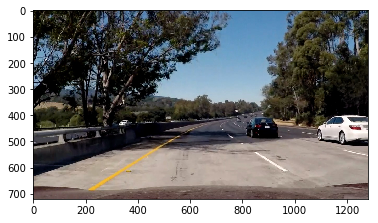

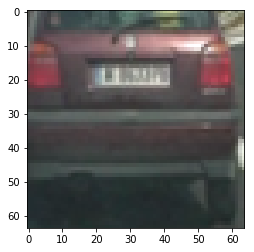

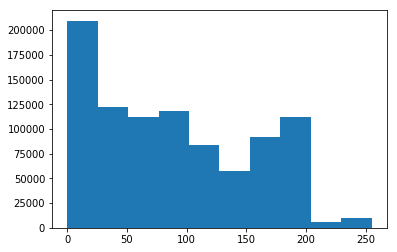

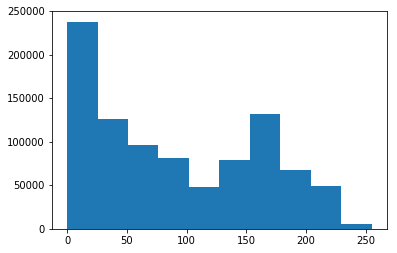

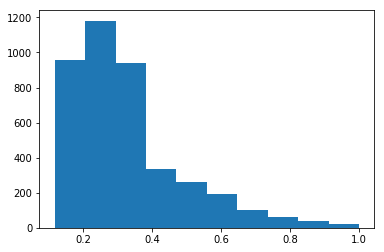

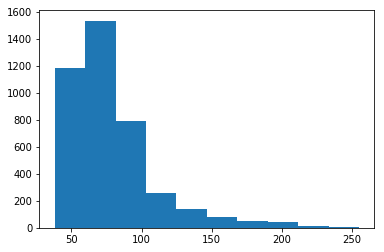

In [247]:
plt.imshow(jpg_mp)
plt.show()
plt.imshow(png_mp)
plt.show()
plt.hist(jpg_mp[:,:,0].ravel())
plt.show()
plt.hist(jpg_cv[:,:,0].ravel())
plt.show()
plt.hist(png_mp[:,:,0].ravel())
plt.show()
plt.hist(png_cv[:,:,0].ravel())
plt.show()